In [ ]:
#!pip install tensorflow
#!pip install mdtraj
#!conda install -y -c conda-forge pdbfixer
#!conda install -y boost-cpp boost py-boost
#!pip install rdkit
#!pip install git+https://github.com/samoturk/mol2vec
#!pip install matminer
#!pip install mordred
#!pip install networkx[default]
#!conda install -y -c conda-forge openmm
#!pip install pymatgen
#! pip install deepchem==2.4

In [25]:
import deepchem as dc
# import image module
from IPython.display import Image
import rdkit
from scripts.help_funcs import *

Understanding the details of how, where, and when molecules bind to proteins is critical
to understanding their functions and developing drugs. If we can coopt the signaling
mechanisms of cells in the human body, we can induce desired medical
responses in the body.

### Biophysical Featurizations

#### From Molecules to Features

grid featurization, explicitly searches a 3D structure
for the presence of critical physical interactions such as hydrogen bonds and salt
bridges (more on these later), which are known to play an important role in determining
protein structure

DeepChem has such a featurizer available. Its RdkitGridFeaturizer

#### Hydrogen bonds

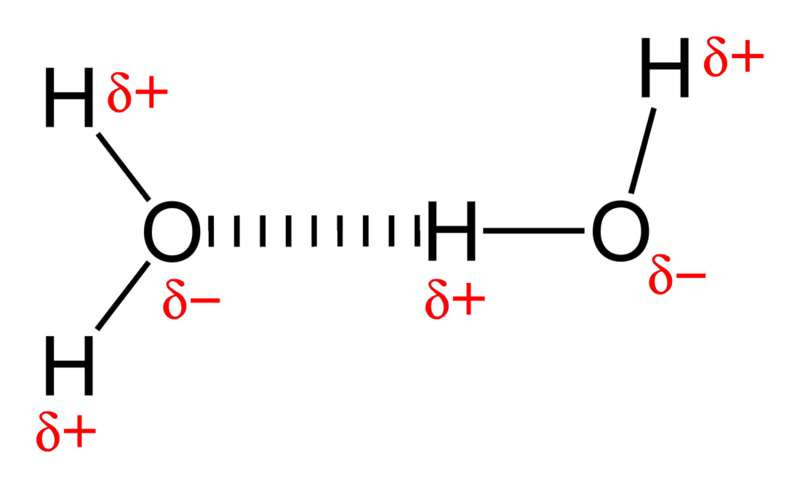

In [26]:
Image('assets/Hydrogen-bonding-in-water-2D.png', width=600, height=600)

#### Salt bridges

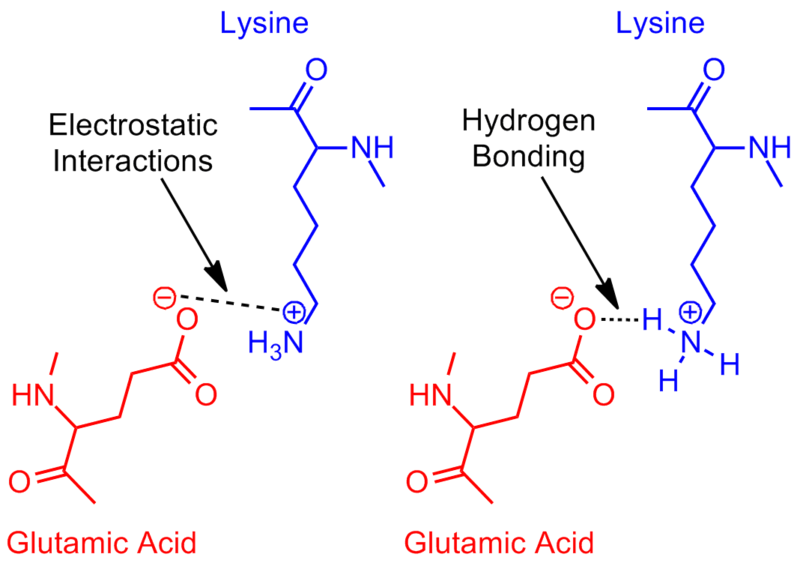

In [27]:
Image('assets/800px-Revisited_Glutamic_Acid_Lysine_salt_bridge.png', width=600, height=600)

#### Pi-stacking interactions

In chemistry, pi stacking (also called π–π stacking) refers to the presumptive attractive, noncovalent pi interactions (orbital overlap) between the pi bonds of aromatic rings.

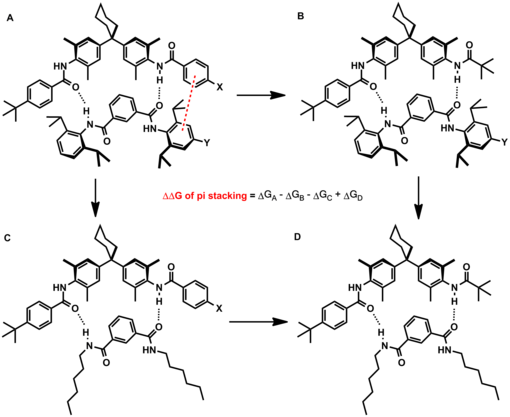

In [28]:
Image('assets/510px-Double_Mutant_Cycle.png', width=600, height=600)

#### Fingerpint

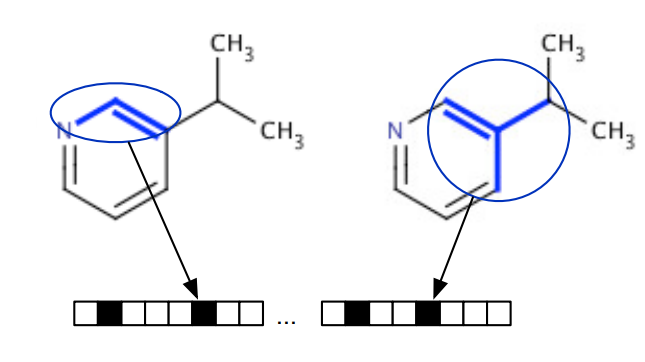

In [29]:
Image('assets/Fingerprint.png', width=600, height=600)

#### Cation-π 

Cation–π interaction is a noncovalent molecular interaction between the face of an electron-rich π system (e.g. benzene, ethylene, acetylene) and an adjacent cation (e.g. Li+, Na+). 

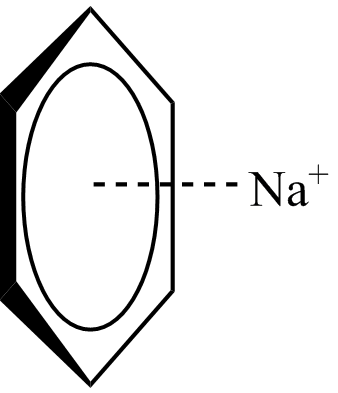

In [19]:
Image('assets/Benzene-sodium.png', width=300, height=400)

### Atomic Featurization

Featurization for a given molecule could simply involve
computing this (N, 3) array and passing it to a suitable machine learning algorithm.<br/>
The model could then learn for itself what features were important, rather than relying
on a human to select them and code them by hand. <br/>
In fact, this turns out to work—with a couple of extra steps. The (N, 3) position
array doesn’t distinguish atom types, so you also need to provide another array that
lists the atomic number of each atom.

DeepChem provides a dc.feat.ComplexNeighborListFragmentAtomicCoordinates

### Protein-Ligand

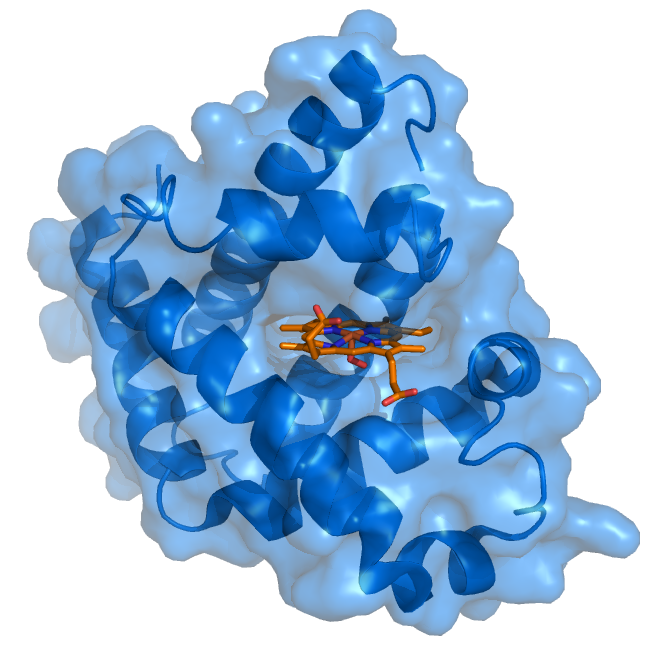

In [30]:
Image('assets/Myoglobin_and_heme.png')

#### PDBBind Dataset

The PDBBind dataset contains a large number of biomolecular crystal structures and
their binding affinities.

A binding affinity is the experimentally measured affinity of two molecules to form a complex, with
the two molecules interacting. If it is energetically favorable to form such a complex,
the molecules will spend more time in that configuration as opposed to another one.

In [31]:
featurizer = dc.feat.RdkitGridFeaturizer(voxel_width=2.0,
                                        sanitize=True, flatten=True,
                                        feature_types=['hbond', 'salt_bridge', 'pi_stack', 'cation_pi'])
#featurizer = dc.feat.Mol2VecFingerprint()

tasks, datasets, transformers = load_pdbbind(featurizer=featurizer,
                                                        splitter="random",
                                                        set_name ='core',
                                                        pocket=True,
                                                        data_dir='data/pdbbind',
                                                        save_dir='data/pdbbind')
train_dataset, valid_dataset, test_dataset = datasets



In [32]:
train_dataset

<DiskDataset X.shape: (154, 3584), y.shape: (154,), w.shape: (154,), ids: ['3g2z' '4djv' '2cet' ... '2jdm' '2pcp' '1w3k'], task_names: [0]>

### DeepChem Built-in Estimator (Wrapper)

In [33]:
# Create and train the model.
n_features = train_dataset.X.shape[1]
model = dc.models.MultitaskRegressor(
        n_tasks=len(tasks),
        n_features=n_features,
        layer_sizes=[2000, 1000],
        dropouts=0.5,
        model_dir="pdbbind_nn",
        learning_rate=0.0003)


In [34]:
model.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 3584)]       0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 2000)         7170000     ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 switched_dropout_2 (SwitchedDr  (None, 2000)        0           ['dense_5[0][0]',                
 opout)                                                           'input_5[0][0]']          

In [ ]:
model.fit(train_dataset, nb_epoch=1)

In [ ]:
# Evaluate it.
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
train_scores = model.evaluate(train_dataset, [metric], transformers)
test_scores = model.evaluate(test_dataset, [metric], transformers)
print("Train scores")
print(train_scores)
print("Test scores")
print(test_scores)

### Using Keras Models with DeepChem

In [24]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations

features = tf.keras.Input(shape=(n_features, ))
prev = layers.Dense(units=100)(features)
prev = layers.Dropout(rate=0.5)(prev)
logits = layers.Dense(units=1)(prev)
output = layers.Activation(activations.linear)(logits)
keras_model = tf.keras.Model(inputs=features, outputs=[output, logits])
model = dc.models.KerasModel(
    keras_model,
    loss=dc.metrics.rms_score,
    output_types=['RMS', 'loss'],
    batch_size=1000,
    model_dir='tf')